In [1]:
import _init_paths
import numpy as np
from lib.config import cfg
from lib.config import update_config
update_config(cfg)
from lib.common.humanKeypoints import humanKeypoints 

infantKeypoint = humanKeypoints('infant_60.mov')
variability = infantKeypoint.getKeypointVariability()


In [2]:
from lib.common.visualization import visualization

average_movement = infantKeypoint.getAverageMovement(eachAverageTime=120)
average_movement = np.delete(average_movement, [0,1,2,3,4], axis=0)
average_movement =average_movement[..., ::2]
# print(average_movement.shape)
v = visualization(infantKeypoint)
# v.draw_variability()

In [3]:
from lib.utils.peakFeature import peakFeature
import pandas as pd
from os import listdir
from os.path import isfile, join
video_floder_path = './data/medias'
video_names = [f for f in listdir(video_floder_path) if isfile(join(video_floder_path, f))]

df = pd.DataFrame()
print(df.empty)
for video_name in video_names:
    infantKeypoint = humanKeypoints(video_name)
    average_movement = infantKeypoint.getAverageMovement()
    pf = peakFeature(average_movement, video_name)
    features = pf.getPeakFeatures()
    if df.empty:
        df = pd.DataFrame(features)
    else:
        df = pd.concat([df, pd.DataFrame(features)])

True


     acceleration  deceleration  movment_duration      mean       std  \
0        0.000239      0.000262                31  0.007189  0.001555   
1        0.000274     -0.000007               120  0.005721  0.001261   
2        0.000633      0.000173               241  0.007115  0.002513   
3        0.000393      0.000088               326  0.005479  0.000780   
4        0.000098      0.000086                37  0.005504  0.000743   
..            ...           ...               ...       ...       ...   
136      0.001168      0.001124                55  0.016257  0.004393   
137      0.000209      0.000459                32  0.009754  0.001557   
138      0.000755      0.000898                31  0.009723  0.004218   
139      0.001375      0.000149               150  0.009148  0.001475   
140      0.002926      0.000711               135  0.011774  0.002784   

     peaks_num  
0            1  
1            3  
2            6  
3            8  
4            1  
..         ...  
136 

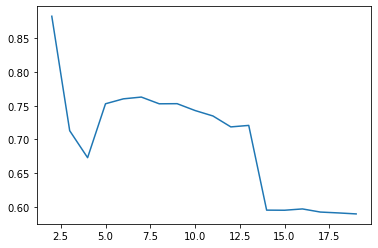

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt

# X = df[df['joint_index'].isin(cfg.ARM_INDEX)]
# X = X.loc[:,'acceleration':]
X = df.loc[:,'acceleration':]
print(X)
sil = []
for k in np.arange(2,20):
    kmeans = KMeans(n_clusters=k, random_state=2).fit(X)
    labels = kmeans.labels_
    sil.append(silhouette_score(X, labels, metric = 'euclidean'))

plt.plot(np.arange(2,20), sil)
print(kmeans.labels_)

[ 5  6  7  8  9 10 11 12 13 14 15]


NameError: name 'targ' is not defined

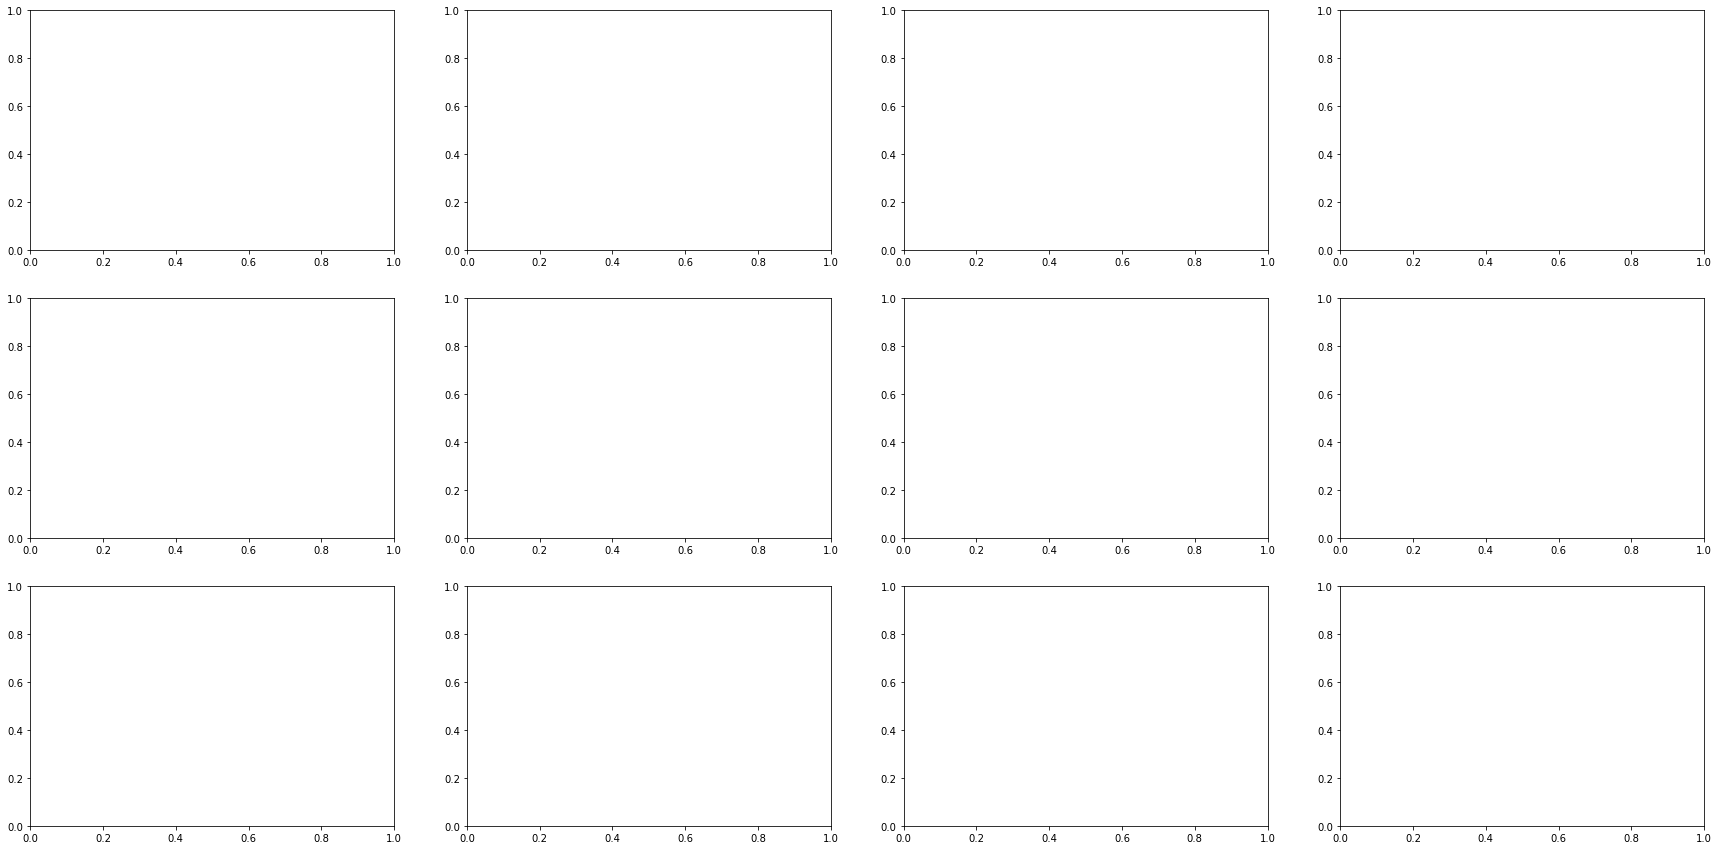

In [16]:
import matplotlib.pyplot as plt 
kmeans = KMeans(n_clusters=9, random_state=2).fit(X)
ndf = df
ndf['peakCluster'] = kmeans.labels_

fig, ax = plt.subplots(3,4,figsize=(30, 15))
segments = []
all_peaks = []
for i in np.arange(5,17):
    target = ndf[ndf['joint_index'] == i and ndf['video_index'] == 'infant5_48.mov']

    row = int(i/4)
    col = i%4
    ax[row][col].set_title(i+5)
    ax[row][col].plot(peaks, target[peaks], "xr")
    ax[row][col].plot(segment, target[segment], "dr"); 
    ax[row][col].plot(target); 
    ax[row][col].legend(['peak'])
    ax[row][col].legend(['segment'])

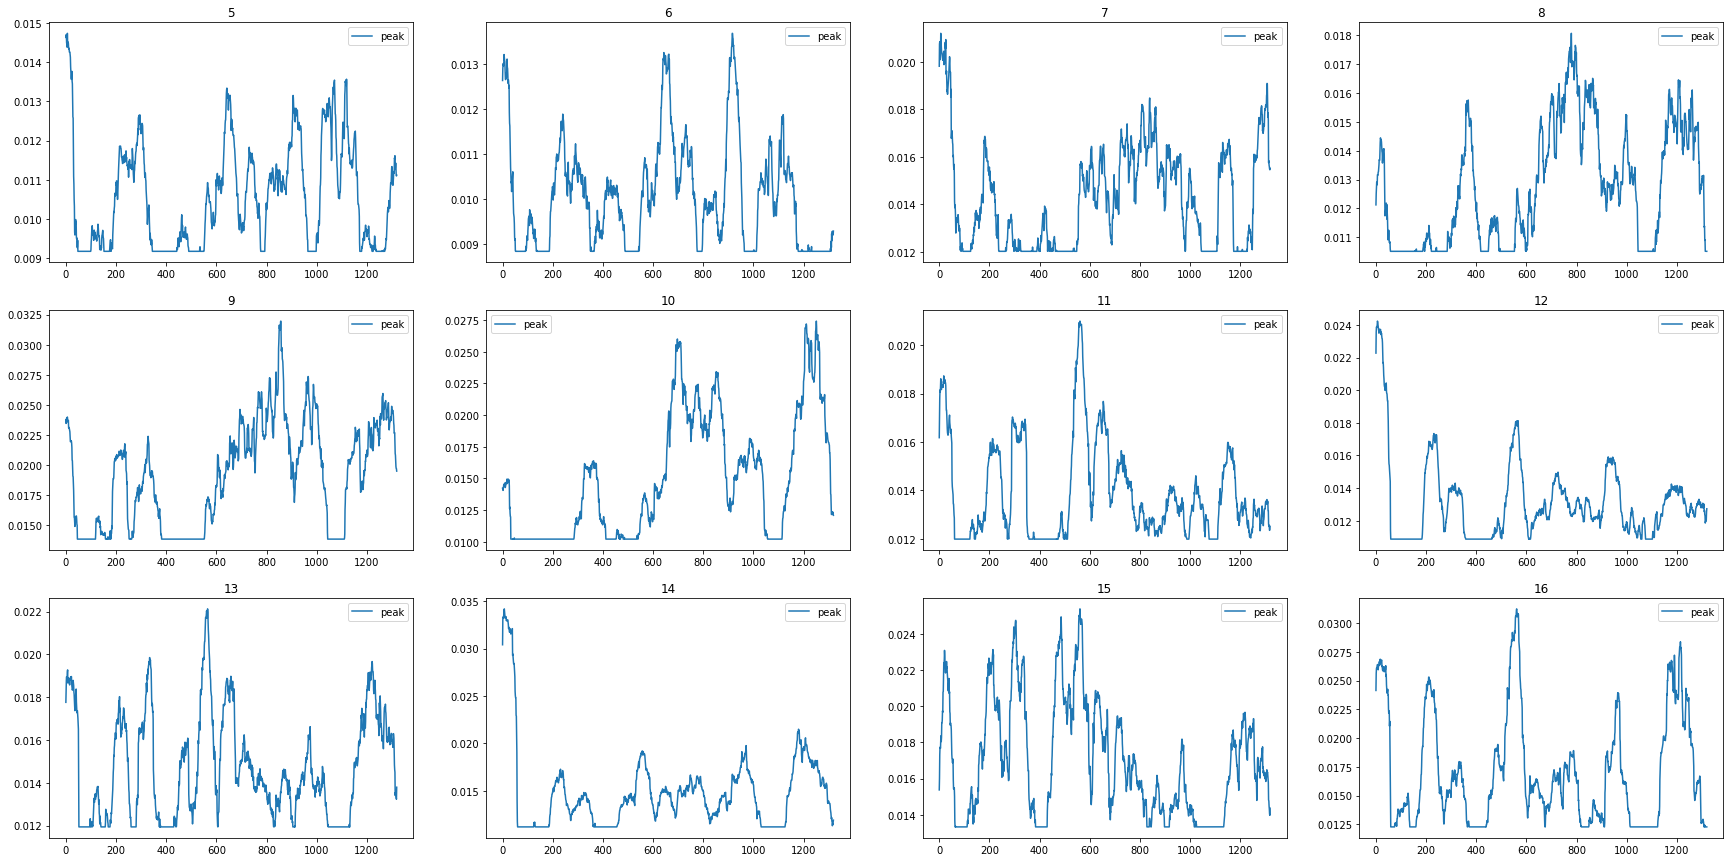

In [3]:
import matplotlib.pyplot as plt 
from scipy.signal import find_peaks

fig, ax = plt.subplots(3,4,figsize=(30, 15))
means = []

for i in range(average_movement.shape[0]):
    target = average_movement[i]
    # if(mean>0.01): mean = 0.01
    percentile = np.percentile(target, 50)
    mean = np.mean(target[target<percentile])
    # percentile = np.percentile(target, 50)
    highMean = np.mean(target[target>percentile])
    means.append(mean)
    target[target<mean] = mean
    # peaks, _ = find_peaks(target, prominence=highMean/10)
    mean = np.full(target.shape[0], mean)
    row = int(i/4)
    col = i%4
    ax[row][col].set_title(i+5)
    # ax[row][col].plot(peaks, target[peaks], "xr"); 
    ax[row][col].plot(target); 
    # ax[row][col].plot(mean); 
    ax[row][col].legend(['peak'])
    

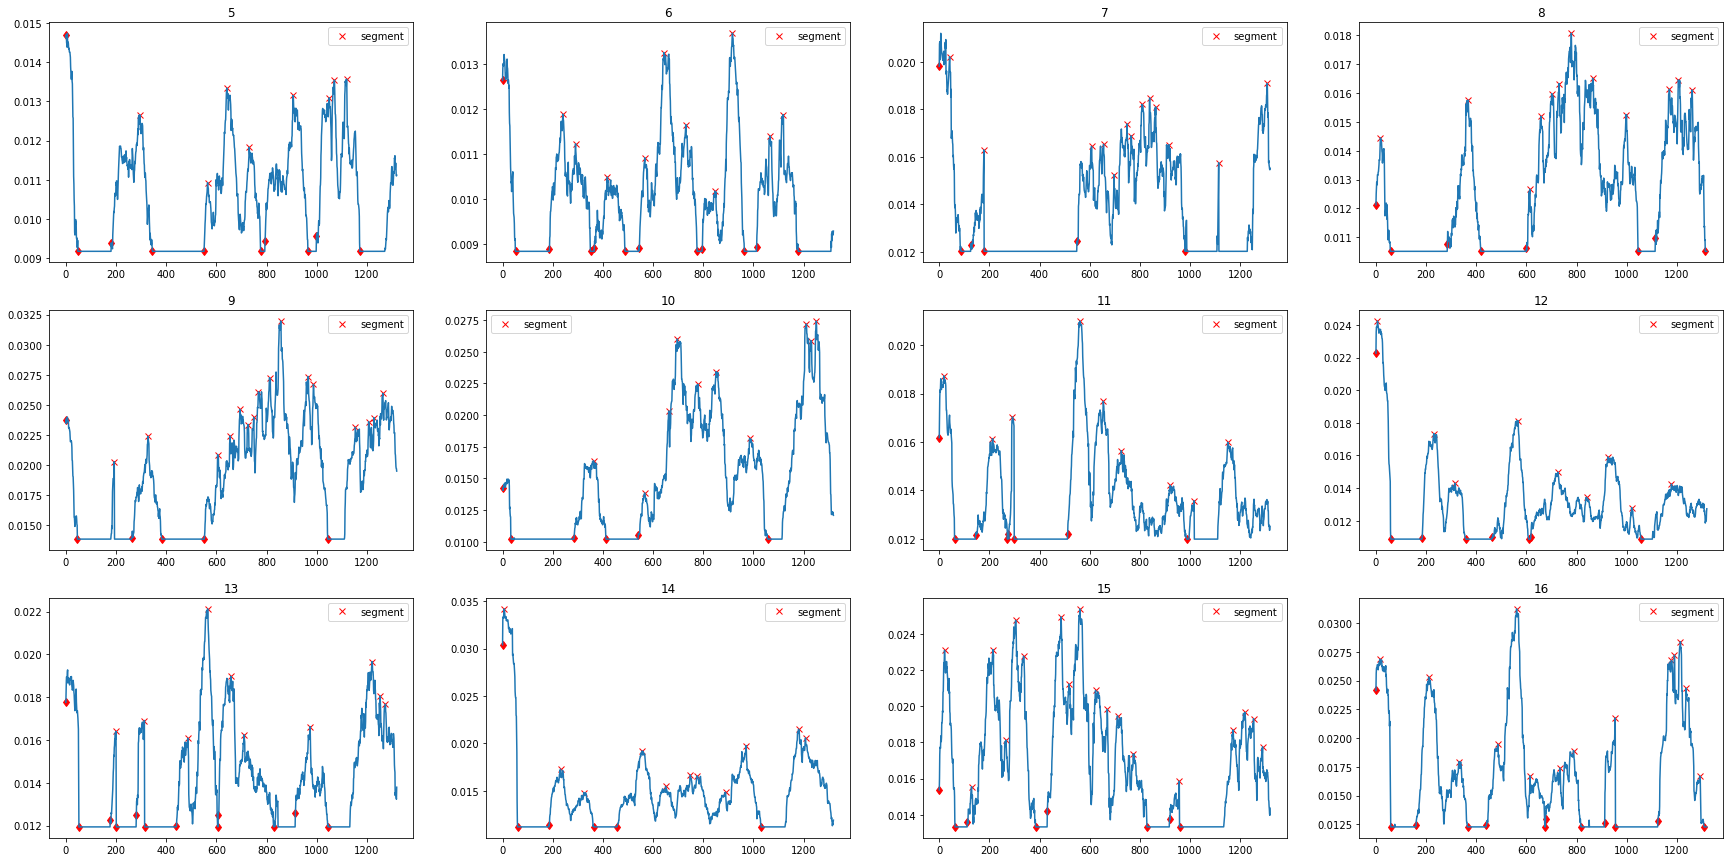

In [4]:
from lib.utils.peakFeature import peakFeature

# new_ma = peakSegment(average_movement, peaks, mean)


fig, ax = plt.subplots(3,4,figsize=(30, 15))
segments = []
all_peaks = []
for i in range(average_movement.shape[0]):
    new_ma = peakFeature.removedMovingAverageNoise(average_movement[i], means[i])
    segment = peakSegment(new_ma, means[i])
    segments.append(segment)
    target = new_ma

    percentile = np.percentile(target, 50)
    highMean = np.mean(target[target>percentile])
    peaks, _ = find_peaks(target, prominence=highMean/10)
    all_peaks.append(peaks)

    row = int(i/4)
    col = i%4
    ax[row][col].set_title(i+5)
    ax[row][col].plot(peaks, target[peaks], "xr")
    ax[row][col].plot(segment, target[segment], "dr"); 
    ax[row][col].plot(target); 
    ax[row][col].legend(['peak'])
    ax[row][col].legend(['segment'])

In [5]:
from lib.utils.featureExtraction import peakAcceleration

for i in range(average_movement.shape[0]):
    print(peakAcceleration(average_movement[i], all_peaks[i], segments[i]))

[7.797122004759953e-06, 2.8702149558705786e-05, 0.00019559205873248336, 3.31881576332046e-05, 0.0002307889999625803]
[9.583770872026182e-05, 8.227674200117412e-05, 3.001067676830978e-05, 0.00014953753688069028, 9.273951748042716e-05, 8.894802170987553e-05]
[9.751104841125619e-06, 7.719088910601656e-05, 0.0007059228692957018]
[0.00012908768773019758, 5.995587309111291e-05, 0.0005343252520434282, 0.00019444282337437345]
[4.0829194245995196e-05, 0.00013046413682872484, 0.0016180260563282542]
[4.064633202731285e-05, 7.80262728743527e-05, 0.0006531203709853282]
[0.0001417758194492797, 5.96366469928171e-05, 0.00025338326857031934, 0.0002759414318749706]
[0.00032705392240060745, 0.00017062186278342622, 7.008413133342824e-05, 0.00011778768105933729]
[0.00021649477873921904, 0.0001797720734924235, 0.0001385513070159766, 0.0002168117476349669, 0.00017283800339235964, 6.815674809202781e-05]
[0.0005408992444027812, 0.00015982225716122802, 0.00034765291244264043]
[0.00036720887922273314, 0.00057506

In [6]:
import seaborn as sns
sns.set_style("white")
kwargs = dict(bins=100)

sns.distplot(average_movement[16], **kwargs, color='dodgerblue', label='16')
sns.distplot(average_movement[15], **kwargs, color='g', label='15')
sns.distplot(average_movement[14], color="deeppink", label="14")
plt.legend()

IndexError: index 16 is out of bounds for axis 0 with size 12

In [ ]:
from scipy.stats import kurtosis
from scipy.stats import skew

kur = kurtosis(average_movement[16])
skewness = skew(average_movement[16])
print(kur)
print(skewness)

In [ ]:
from lib.utils.featureExtraction import extractFeatures

features = extractFeatures(infantKeypoint)

# print(features.head)
# print(ef)
# print(features)
t = features.iloc[:].values
print(features.shape)
# print(t.reshape(-1))
print(np.concatenate(t[0]))
